In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
IMG_DIR = 'data/images/'
LBL_DIR = 'data/annotations/'

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 10
num_classes = 37
batch_size = 16
learning_rate = 0.001

In [3]:
class OxfordPetsDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.pets_df = train_df = pd.read_csv(csv_path, sep=' ', names = ["Image", "ID", "Species", "Breed"])
        self.img_dir = img_dir
        self.transform = transform
    def __len__(self):
        return len(self.pets_df)
    def __getitem__(self, idx):
        img_name = self.img_dir + self.pets_df.iloc[idx, 0] + '.jpg'
        image = Image.open(img_name).convert('RGB')
        label = self.pets_df.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return (image, label)
    
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # C, H, W -> H, W, C
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    # to show unnormalized image
    inp = std * inp + mean
    
    return inp

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(), 
                                       normalize
                                      ])

test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      normalize
                                     ])

trainset = OxfordPetsDataset(LBL_DIR+'trainval.txt', IMG_DIR, transform=train_transforms)
testset = OxfordPetsDataset(LBL_DIR+'test.txt', IMG_DIR, transform=test_transforms)
train_loader = DataLoader(trainset, batch_size=batch_size)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [16]:
for img, lbl in test_loader:
    img = img.to(device)

RuntimeError: CUDA error: device-side assert triggered

In [5]:
sample = next(iter(test_loader))
img, lbl = sample
print(img.shape)

torch.Size([16, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


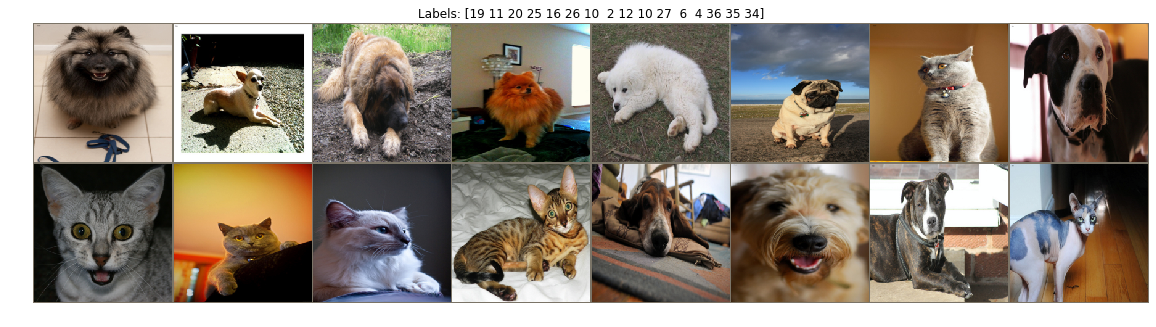

In [6]:
out = torchvision.utils.make_grid(img)
plt.figure(figsize=(20,10));
plt.title(f"Labels: {lbl.numpy()}")
plt.axis('off');
plt.imshow(imshow(out));

In [7]:
# Load Pretrained Network and Freeze Layers except final classifer layers
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
squeezenet = torchvision.models.squeezenet1_1(pretrained=True)
set_parameter_requires_grad(squeezenet, True)

# Replace 1000 classes from imagenet pretraining to 10 for CIFAR 10
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
squeezenet.num_classes = num_classes
squeezenet = squeezenet.to(device)

/home/pablo/anaconda3/envs/gcp/lib/python3.7/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/home/pablo/anaconda3/envs/gcp/lib/python3.7/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


In [8]:
resnet50 = torchvision.models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Linear(512, num_classes)

In [9]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=learning_rate)

In [10]:
def train(data_loader, model, criterion, optimizer, epoch, train_step, device):
    model.train()
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward Pass
        output = model(images)
        loss = criterion(output, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}")
        train_step +=1
        
    return train_step

def test(data_loader, model, criterion, test_step, device):
    squeezenet.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = squeezenet(images)
            
            # Accuracy Measurement
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            acc =  (predicted == labels).sum().item() / labels.size(0)
            test_step +=1
                
        total_acc = correct /total
        print(f'Test Accuracy of the model on the test images: {total_acc}')
        
        return test_step

In [11]:
# Train and Test SqueezeNet
train_step = 0
test_step = 0
for epoch in range(num_epochs):
    train_step = train(train_loader, squeezenet, criterion, optimizer, epoch, train_step, device)
    test_step = test(test_loader, squeezenet, criterion, test_step, device)

Epoch [1/10], Step [100/230], Loss: 4.8209


RuntimeError: CUDA error: device-side assert triggered

## GCP Steps
1. https://cloud.google.com/deep-learning-vm/docs/quickstart-marketplace
2. https://cloud.google.com/free/
3. 